# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [17]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [2]:
websites = pd.read_csv('../website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [159]:
# Your code here
websites.info()
websites.head()
websites['Type'].unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 0 to 1780
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   URL_LENGTH            1779 non-null   int64  
 1   CHARSET               1779 non-null   object 
 2   SERVER                1779 non-null   object 
 3   WHOIS_COUNTRY         1779 non-null   object 
 4   DIST_REMOTE_TCP_PORT  1779 non-null   int64  
 5   REMOTE_IPS            1779 non-null   int64  
 6   APP_BYTES             1779 non-null   int64  
 7   SOURCE_APP_BYTES      1779 non-null   int64  
 8   APP_PACKETS           1779 non-null   int64  
 9   DNS_QUERY_TIMES       1779 non-null   float64
 10  Type                  1779 non-null   int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 231.3+ KB


array([1, 0], dtype=int64)

# Your comment here

What the dataset looks like?
Features of web sites

What are the data types?
object and numeric

Which columns contain the features of the websites?


Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?


Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?


#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

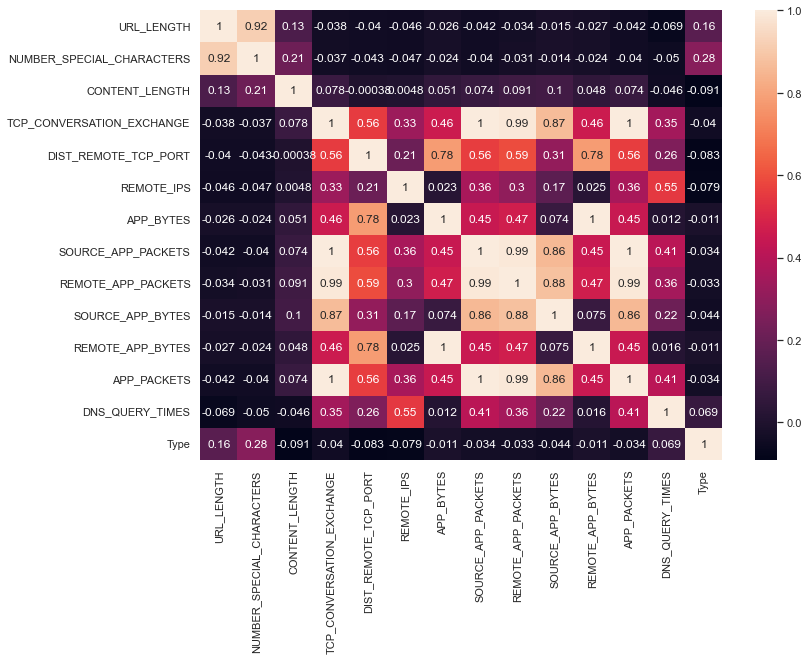

In [22]:
# Your code here
corr_matrix = websites.corr()
sns.heatmap(corr_matrix, annot = True);
plt.show()
sns.set(rc={'figure.figsize':(20,20)})

In [ ]:
# Your comment here
#TCP Conversation Exchange
# App Bytes
# Source App Packets
# Remote App Packets
# App Packets

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [26]:
# Your code here
websites.drop(columns='TCP_CONVERSATION_EXCHANGE', inplace = True)

KeyError: "['TCP_CONVERSATION_EXCHANGE'] not found in axis"

In [36]:
websites.drop(columns='NUMBER_SPECIAL_CHARACTERS', inplace = True)

In [30]:
websites.drop(columns='SOURCE_APP_PACKETS', inplace = True)

In [32]:
websites.drop(columns='REMOTE_APP_PACKETS', inplace = True)

In [34]:
websites.drop(columns='REMOTE_APP_BYTES', inplace = True)

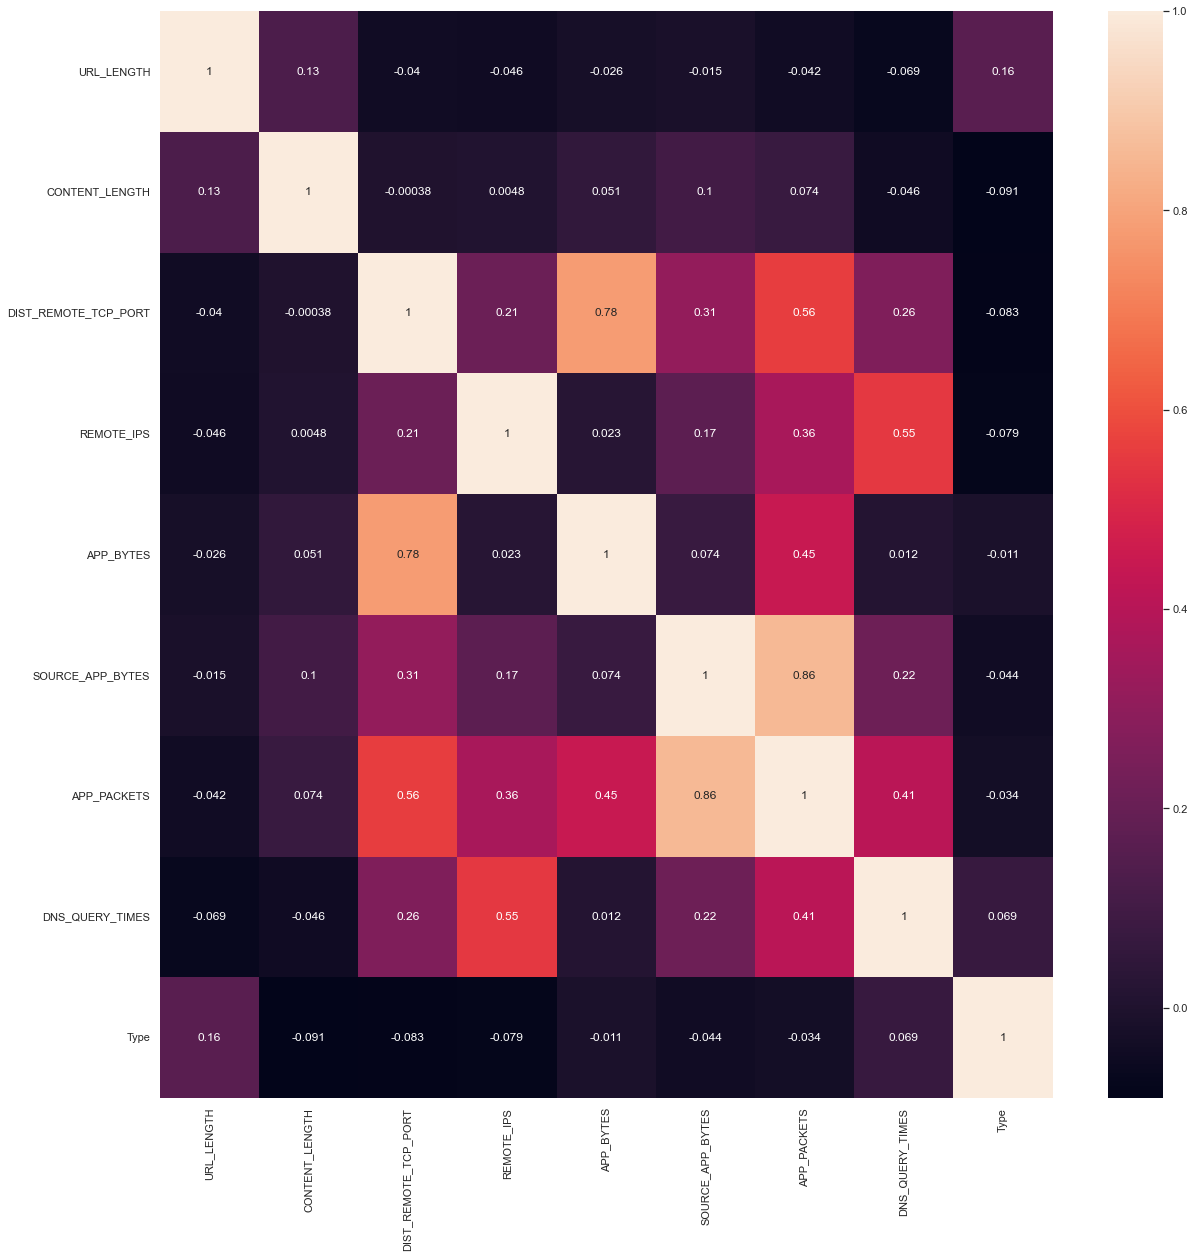

In [37]:
corr_matrix = websites.corr()
sns.heatmap(corr_matrix, annot = True);

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [39]:
# Your code here
websites.isnull().sum()

URL                       0
URL_LENGTH                0
CHARSET                   0
SERVER                    1
CONTENT_LENGTH          812
WHOIS_COUNTRY             0
WHOIS_STATEPRO            0
WHOIS_REGDATE             0
WHOIS_UPDATED_DATE        0
DIST_REMOTE_TCP_PORT      0
REMOTE_IPS                0
APP_BYTES                 0
SOURCE_APP_BYTES          0
APP_PACKETS               0
DNS_QUERY_TIMES           1
Type                      0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [40]:
# Your code here
websites.drop(columns='CONTENT_LENGTH', inplace = True)

In [47]:
websites.drop(websites[websites.isnull().any(axis=1)].index, inplace = True)
# Your comment here

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [66]:
# Examine missing values in each column
websites.isnull().sum()

URL                     0
URL_LENGTH              0
CHARSET                 0
SERVER                  0
WHOIS_COUNTRY           0
WHOIS_STATEPRO          0
WHOIS_REGDATE           0
WHOIS_UPDATED_DATE      0
DIST_REMOTE_TCP_PORT    0
REMOTE_IPS              0
APP_BYTES               0
SOURCE_APP_BYTES        0
APP_PACKETS             0
DNS_QUERY_TIMES         0
Type                    0
dtype: int64

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [75]:
# Your code here
websites['WHOIS_COUNTRY'].replace('Cyprus', 'CY', inplace=True)
websites['WHOIS_COUNTRY'].replace('us', 'US', inplace=True)
websites['WHOIS_COUNTRY'].replace('se', 'SE', inplace=True)
websites['WHOIS_COUNTRY'].replace('ru', 'RU', inplace=True)
websites['WHOIS_COUNTRY'].replace('us', 'US', inplace=True)
websites['WHOIS_COUNTRY'].replace("[u'GB'; u'UK']", 'UK', inplace= True)
websites['WHOIS_COUNTRY'].replace('United Kingdom', 'UK', inplace = True)
websites['WHOIS_COUNTRY'].replace('GB', 'UK', inplace = True)
websites['WHOIS_COUNTRY'].unique()

array(['None', 'US', 'SC', 'UK', 'RU', 'AU', 'CA', 'PA', 'SE', 'IN', 'LU',
       'TH', 'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'KY', 'AT', 'CZ',
       'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'BR', 'KR', 'HK', 'UA',
       'CH', 'BS', 'PK', 'IT', 'CY', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

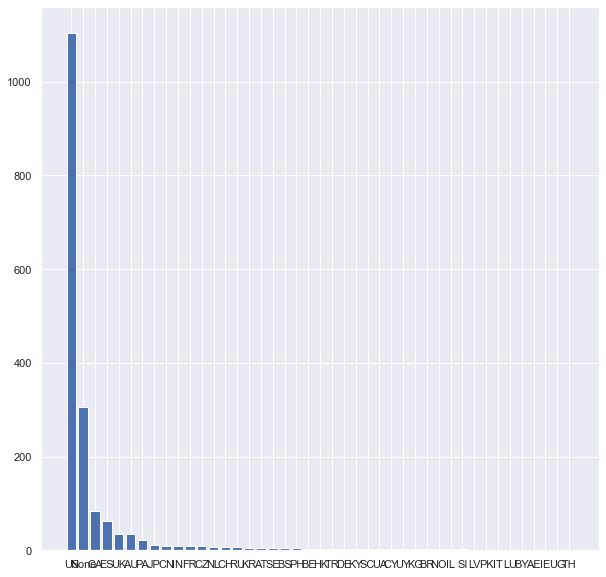

In [101]:
# Your code here
countries = websites['WHOIS_COUNTRY'].value_counts()
plt.bar(countries.index, countries.values)
sns.set(rc={'figure.figsize':(30,30)})

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [120]:
# Your code here

top_10 = ['US', 'None', 'CA', 'ES', 'UK', 'AU', 'PA', 'JP', 'CN', 'IN']
websites['WHOIS_COUNTRY'].value_counts().sort_values(ascending=False)
no_in = ['CZ', 'FR', 'NL', 'CH', 'RU', 'KR', 'AT', 'SE', 'BS', 'PH', 'DE', 'SC', 'KY', 'HK', 'TR', 'BE', 'BR', 'IL', 'NO',
         'SI', 'KG', 'UY', 'CY', 'UA', 'LV', 'PK', 'IT', 'LU', 'BY', 'AE', 'IE', 'UG', 'TH']
websites.replace(no_in, 'OTHER', inplace = True)

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [127]:
# Your code here
websites.drop(['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], axis=1, inplace = True)

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [128]:
# Your code here
websites.dtypes

URL                      object
URL_LENGTH                int64
CHARSET                  object
SERVER                   object
WHOIS_COUNTRY            object
DIST_REMOTE_TCP_PORT      int64
REMOTE_IPS                int64
APP_BYTES                 int64
SOURCE_APP_BYTES          int64
APP_PACKETS               int64
DNS_QUERY_TIMES         float64
Type                      int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [132]:
# Your code here
websites.drop('URL',axis =1, inplace = True)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [134]:
# Your code here
websites['CHARSET'].value_counts()

UTF-8           674
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
None              7
windows-1251      1
ISO-8859          1
windows-1252      1
Name: CHARSET, dtype: int64

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [136]:
# Your code here
websites['SERVER'].unique()

array(['nginx', 'Apache/2.4.10', 'Microsoft-HTTPAPI/2.0', 'None',
       'Apache/2', 'nginx/1.10.1', 'Apache', 'Apache/2.2.15 (Red Hat)',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'openresty/1.11.2.1', 'Apache/2.2.22', 'Apache/2.4.7 (Ubuntu)',
       'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'Oracle-iPlanet-Web-Server/7.0', 'cloudflare-nginx', 'nginx/1.6.2',
       'openresty', 'Heptu web server', 'Pepyaka/1.11.3', 'nginx/1.8.0',
       'nginx/1.10.1 + Phusion Passenger 5.0.30',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5', 'LiteSpeed',
       'Apache/2.4.25 (cPanel) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'tsa_c', 'Apache/2.2.0 (Fedora)', 'Apache/2.2.22 (Debian)',
       'Apache/2.2.15 (CentOS)', 'Apache/2.4.25',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips'

![Think Hard](../think-hard.jpg)

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [150]:
# Your code here
websites['SERVER'] = np.where(websites['SERVER'].str.contains('Apache'), 'Apache', np.where(websites['SERVER'].str.contains('Microsoft'), 'Microsoft', 
                                                                                         np.where(websites['SERVER'].str.contains('nginx'), 'nginx', 'OTHER')))

In [153]:
# Count `SERVER` value counts here
websites['SERVER'].unique()

array(['nginx', 'Apache', 'Microsoft', 'OTHER'], dtype=object)

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [156]:
# Your code here
website_dummy = pd.get_dummies(websites, drop_first=True)
website_dummy.head(10)

,URL_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,CHARSET_ISO-8859-1,CHARSET_None,...,WHOIS_COUNTRY_CA,WHOIS_COUNTRY_CN,WHOIS_COUNTRY_ES,WHOIS_COUNTRY_IN,WHOIS_COUNTRY_JP,WHOIS_COUNTRY_None,WHOIS_COUNTRY_OTHER,WHOIS_COUNTRY_PA,WHOIS_COUNTRY_UK,WHOIS_COUNTRY_US
0,16,0,2,700,1153,9,2.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,16,7,4,1230,1265,17,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,16,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,17,22,3,3812,18784,39,8.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,17,2,5,4278,129889,61,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,18,6,9,894,838,11,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,18,0,3,1189,8559,14,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,19,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,20,0,0,0,213,2,2.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
9,20,0,0,0,62,2,2.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [160]:
# Your code here
website_dummy.columns

Index(['URL_LENGTH', 'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES',
       'SOURCE_APP_BYTES', 'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type',
       'CHARSET_ISO-8859-1', 'CHARSET_None', 'CHARSET_UTF-8',
       'CHARSET_iso-8859-1', 'CHARSET_us-ascii', 'CHARSET_utf-8',
       'CHARSET_windows-1251', 'CHARSET_windows-1252', 'SERVER_Microsoft',
       'SERVER_OTHER', 'SERVER_nginx', 'WHOIS_COUNTRY_CA', 'WHOIS_COUNTRY_CN',
       'WHOIS_COUNTRY_ES', 'WHOIS_COUNTRY_IN', 'WHOIS_COUNTRY_JP',
       'WHOIS_COUNTRY_None', 'WHOIS_COUNTRY_OTHER', 'WHOIS_COUNTRY_PA',
       'WHOIS_COUNTRY_UK', 'WHOIS_COUNTRY_US'],
      dtype='object')

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [162]:
from sklearn.model_selection import train_test_split

# Your code here:
y = website_dummy['Type']
x = website_dummy[['URL_LENGTH', 'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES',
       'SOURCE_APP_BYTES', 'APP_PACKETS', 'DNS_QUERY_TIMES',
       'CHARSET_ISO-8859-1', 'CHARSET_None', 'CHARSET_UTF-8',
       'CHARSET_iso-8859-1', 'CHARSET_us-ascii', 'CHARSET_utf-8',
       'CHARSET_windows-1251', 'CHARSET_windows-1252', 'SERVER_Microsoft',
       'SERVER_OTHER', 'SERVER_nginx', 'WHOIS_COUNTRY_CA', 'WHOIS_COUNTRY_CN',
       'WHOIS_COUNTRY_ES', 'WHOIS_COUNTRY_IN', 'WHOIS_COUNTRY_JP',
       'WHOIS_COUNTRY_None', 'WHOIS_COUNTRY_OTHER', 'WHOIS_COUNTRY_PA',
       'WHOIS_COUNTRY_UK', 'WHOIS_COUNTRY_US']]

X_train, X_test, y_train, y_test = train_test_split(x,y,train_size = 0.8)


#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [168]:
# Your code here:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [169]:
# Your code here:
logistic_model.fit(X_train, y_train)

C:\Users\angel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [176]:
# Your code here:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_pred = logistic_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[301,   8],
       [ 36,  11]], dtype=int64)

What are your thoughts on the performance of the model? Write your conclusions below.

In [177]:
# Your conclusions here:
accuracy_score(y_test, y_pred)


0.8764044943820225

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [185]:
# Your code here:

from sklearn.neighbors import KNeighborsClassifier
neighbors_model = KNeighborsClassifier(n_neighbors=3)
neighbors_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [193]:
# Your code here:
y_pred_neighbors = neighbors_model.predict(X_test)
confusion_matrix(y_test, y_pred_neighbors)
accuracy_score(y_test, y_pred_neighbors)

array([[294,  15],
       [ 13,  34]], dtype=int64)

#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [192]:
# Your code here:
neighbors_model5 = KNeighborsClassifier(n_neighbors=5)
neighbors_model5.fit(X_train, y_train)
y_pred_neighbors5 = neighbors_model5.predict(X_test)
confusion_matrix(y_test, y_pred_neighbors5)
accuracy_score(y_test, y_pred_neighbors5)

array([[296,  13],
       [ 12,  35]], dtype=int64)

Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [191]:
# Your conclusions here:

#Yes there was an improvement

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [ ]:
# Your code here